In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#Data Transformations and Loading
transform = T.Compose([
    T.ToTensor(),
    T.Resize(64), #GANS expects input size of 64*64
    T.Normalize(0.5,0.5),
])

dataset = torchvision.datasets.FashionMNIST(root='./data',download=True,transform=transform)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.9MB/s]


In [4]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [25]:
#classes_to_focus = ['Trouser','Sneaker','Pullover']
classes_to_focus = ['Ankle boot','Coat','Bag']


images2focus = torch.Tensor()
for i in range(len(classes_to_focus)):
  classidx = dataset.classes.index(classes_to_focus[i])
  images2focus = torch.cat((images2focus,torch.where(dataset.targets==classidx)[0]),0).type(torch.long)
  print(f'Added class {classes_to_focus[i]} (index {classidx})')

Added class Ankle boot (index 9)
Added class Coat (index 4)
Added class Bag (index 8)


In [6]:
images2focus

tensor([   16,    21,    38,  ..., 59977, 59981, 59993])

In [7]:
batchsize = 100
sampler = torch.utils.data.sampler.SubsetRandomSampler(images2focus)
data_loader = DataLoader(dataset,sampler=sampler,batch_size = batchsize,drop_last=True)

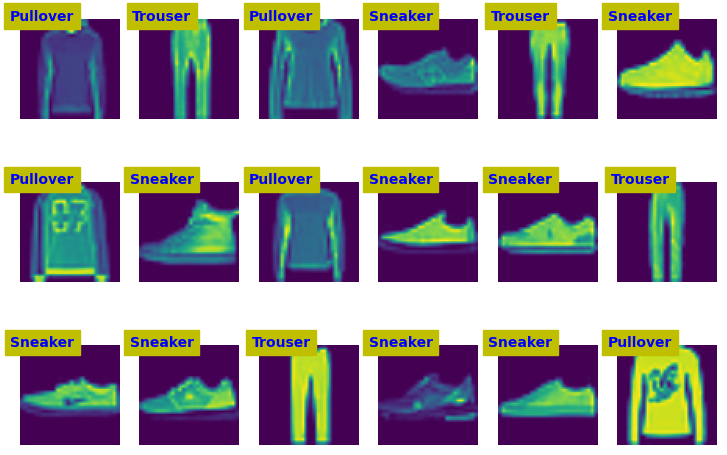

In [8]:
#view some images
X,y = next(iter(data_loader))

fig, axs = plt.subplots(3,6,figsize=(9,6))

for i, ax in enumerate(axs.flatten()):

  pic = torch.squeeze(X.data[i])
  pic = pic/2 + 0.5


  label = dataset.classes[y[i]]
  ax.imshow(pic)
  ax.text(14,0,label,ha='center',fontweight='bold',color ='blue', backgroundcolor='y')
  ax.axis('off')



plt.show()

# Create classes for the discriminator and generator

In [9]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()


    #convolutional layers
    self.conv1 = nn.Conv2d(1,64,4,2,1,bias=False)
    self.conv2 = nn.Conv2d(64,128,4,2,1,bias=False)
    self.conv3 = nn.Conv2d(128,256,4,2,1,bias=False)
    self.conv4 = nn.Conv2d(256,512,4,2,1,bias=False)
    self.conv5 = nn.Conv2d(512,1,4,1,0,bias=False)

    #batch norm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)

  def forward(self,x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu_(self.conv2(x),0.2)
    x = self.bn2(x)
    x = F.leaky_relu(self.conv3(x),0.2)
    x = self.bn3(x)
    x = F.leaky_relu(self.conv4(x),0.2)
    x = self.bn4(x)
    return torch.sigmoid(self.conv5(x)).view(-1,1)

In [10]:
dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

In [11]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    #convolutional layers
    self.conv1 = nn.ConvTranspose2d(100,512,4,1,0,bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256,4,2,1,bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128,4,2,1,bias=False)
    self.conv4 = nn.ConvTranspose2d(128,64,4,2,1,bias=False)
    self.conv5 = nn.ConvTranspose2d(64,1,4,2,1,bias=False)


    #batch norm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(64)

  def forward(self,x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = torch.tanh(self.conv5(x))
    return x

In [12]:
gnet = generatorNet()

torch.Size([10, 1, 64, 64])


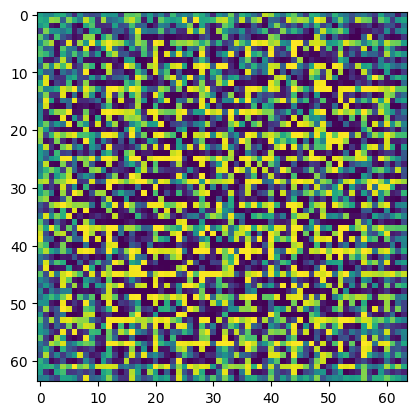

In [13]:
y = gnet(torch.randn(10,100,1,1))
print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().numpy())
plt.show()

In [14]:
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(),lr=0.0002,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(gnet.parameters(),lr=0.0002,betas=(0.5,0.999))

In [15]:
num_epochs = int(2500/len(data_loader))

In [16]:


losses = []
disDecs = []

for ep in range(num_epochs):
  for data, _ in data_loader:
    data = data.to(device)

    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)

    #Train the discriminator
    pred_real = dnet(data) #output of discriminator
    d_loss_real = lossfun(pred_real, real_labels) #all labels are 1

    fake_data = torch.randn(batchsize,100,1,1).to(device) #random no to seed the generator
    fake_images = gnet(fake_data) #op of generator
    pred_fake = dnet(fake_images) #pass through discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels) #all the labels are 0

    d_loss = d_loss_fake + d_loss_real #combined loss

    #backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()


    #Train the generator
    fake_images = gnet(torch.randn(batchsize,100,1,1).to(device))
    pred_fake = dnet(fake_images)

    g_loss = lossfun(pred_fake,real_labels)

    #backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    losses.append([d_loss.item(),g_loss.item()])

    d1 = torch.mean((pred_real> 0.5).float()).detach()
    d2 = torch.mean((pred_fake>0.5).float()).detach()
    disDecs.append([d1,d2])

  msg = f'Finished epoch {ep+1}/{num_epochs}'
  sys.stdout.write('\r'+msg)

losses = np.array(losses)
disDecs = np.array([[d.cpu().numpy() for d in dec] for dec in disDecs])

Finished epoch 13/13

In [17]:
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [18]:
losses

array([[1.47919059, 3.22516632],
       [2.04270625, 2.95978475],
       [1.85567367, 4.63368893],
       ...,
       [0.1202203 , 5.05843449],
       [0.05187751, 4.70558214],
       [0.11242338, 4.03426313]])

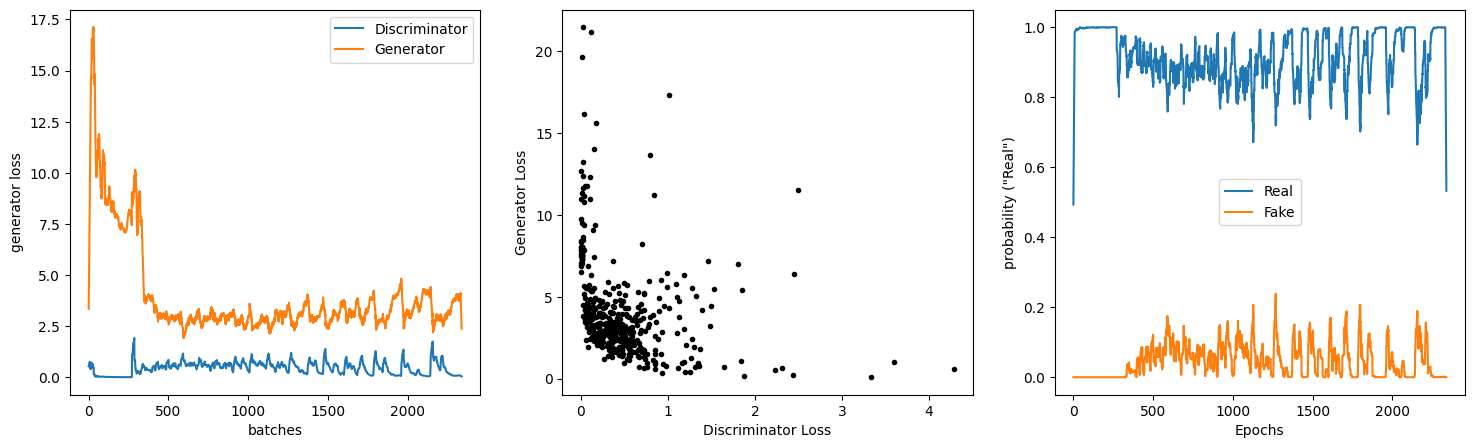

In [21]:
fig, ax = plt.subplots(1,3, figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('batches')
ax[0].set_ylabel('generator loss')
ax[0].legend(['Discriminator','Generator'])

ax[1].plot(losses[::5,0],losses[::5,1],'k.')
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('probability ("Real")')
ax[2].legend(['Real','Fake'])

### Creating some generated fashions

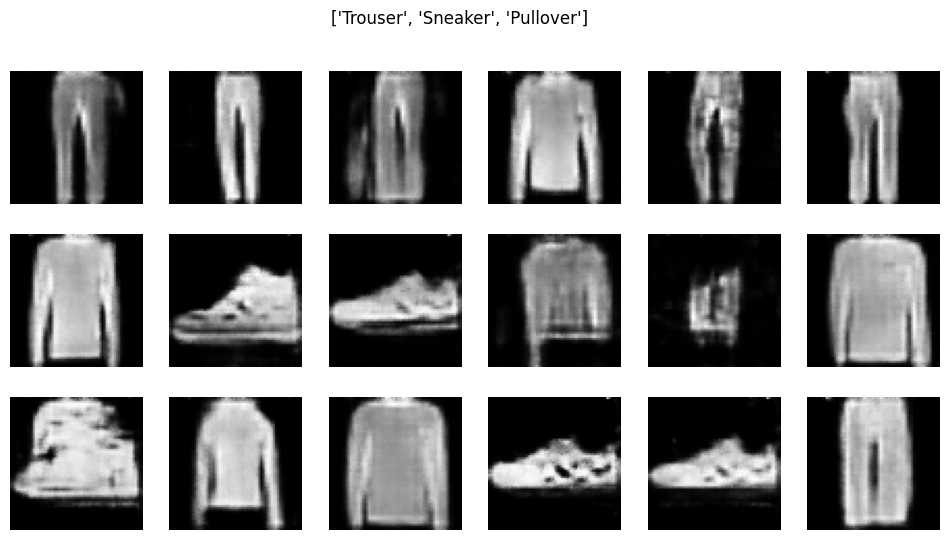

In [24]:
gnet.eval()
fake_data = gnet(torch.randn(batchsize,100,1,1).to(device)).cpu()


fig, axs = plt.subplots(3,6,figsize=(12,6))

for i, ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().squeeze(),cmap='gray')
  ax.axis('off')

plt.suptitle(classes_to_focus,y=0.98)
plt.show()